In [833]:
import torch
import matplotlib.pyplot as plt

In [834]:

def geodesic_point(x0, y0, x1, y1, t):

    is_first_type = torch.isclose(x0, x1, atol=1e-2)
    x_t = torch.zeros_like(x0)
    y_t = torch.zeros_like(y0)

    x_t[is_first_type] = x0[is_first_type]
    d = torch.log(y1[is_first_type] / y0[is_first_type])
    y_t[is_first_type] = y0[is_first_type] * torch.exp(t[is_first_type] * d)

    is_second_type = ~is_first_type

    center = (x0[is_second_type]**2 + y0[is_second_type]**2 - x1[is_second_type]**2 - y1[is_second_type]**2) / (2 * (x0[is_second_type] - x1[is_second_type]))
    radius = torch.sqrt((x0[is_second_type] - center)**2 + y0[is_second_type]**2)

    theta0 = torch.arccos((x0[is_second_type] - center) / radius)
    theta1 = torch.arccos((x1[is_second_type] - center) / radius)

    theta0[theta0 == 0] += torch.pi/2
    theta0[theta0 == torch.pi] -= torch.pi/2
    theta1[theta1 == 0] += torch.pi/2
    theta1[theta1 == torch.pi] -= torch.pi/2

    d = torch.log(torch.tan(theta1 / 2) / torch.tan(theta0 / 2))
    theta_t = 2 * torch.arctan(torch.tan(theta0 / 2) * torch.exp(t[is_second_type] * d))

    x_t[is_second_type] = center + radius * torch.cos(theta_t)
    y_t[is_second_type] = radius * torch.sin(theta_t)

    return x_t, y_t

In [835]:
def geodesic_velocity(x0, y0, x1, y1, t):

    is_first_type = x0 == x1
    vx_t = torch.zeros_like(x0)
    vy_t = torch.zeros_like(y0)

    vx_t[is_first_type] = 0
    d = torch.log(y1[is_first_type] / y0[is_first_type])
    vy_t[is_first_type] = d * y0[is_first_type] * torch.exp(t[is_first_type] * d)

    is_second_type = ~is_first_type

    center = (x0[is_second_type]**2 + y0[is_second_type]**2 - x1[is_second_type]**2 - y1[is_second_type]**2) / (2 * (x0[is_second_type] - x1[is_second_type]))
    radius = torch.sqrt((x0[is_second_type] - center)**2 + y0[is_second_type]**2)

    theta0 = torch.arccos((x0[is_second_type] - center) / radius)
    theta1 = torch.arccos((x1[is_second_type] - center) / radius)

    theta0[theta0 == 0] += torch.pi/2
    theta0[theta0 == torch.pi] -= torch.pi/2
    theta1[theta1 == 0] += torch.pi/2
    theta1[theta1 == torch.pi] -= torch.pi/2

    d = torch.log(torch.tan(theta1 / 2) / torch.tan(theta0 / 2))
    theta_t = 2 * torch.arctan(torch.tan(theta0 / 2) * torch.exp(t[is_second_type] * d))

    dtheta_dt = d * torch.sin(theta_t)
    vx_t[is_second_type] = -radius * torch.sin(theta_t) * dtheta_dt
    vy_t[is_second_type] = radius * torch.cos(theta_t) * dtheta_dt

    return vx_t, vy_t


In [836]:
def transform(x, y):
    return x, np.log(y)

def inverse_transform(x, y):
    return x, np.exp(y)

def velocity_transform(vx, vy, x, y):
    return vx, vy / y

def velocity_inverse_transform(vx, vy, x, y):
    return vx, vy * y

tensor([0.1829]) tensor([1.2980])


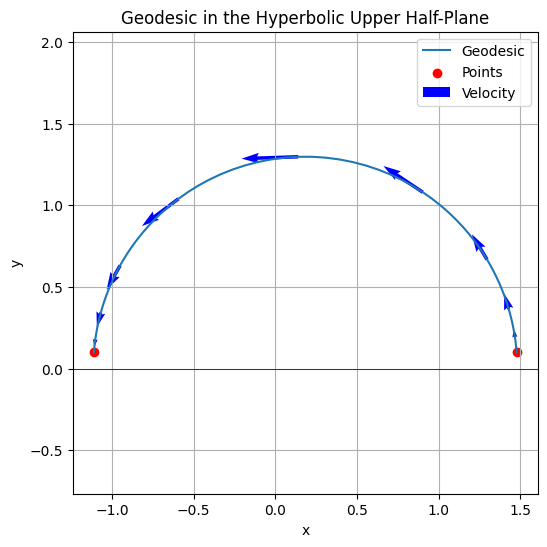

In [837]:
import torch
import matplotlib.pyplot as plt

x0, y0 = torch.rand(1) * 10 - 5, torch.zeros(1)+ 0.1
x1, y1 = torch.rand(1) * 10 - 5, torch.zeros(1) + 0.1

center = (x0**2 + y0**2 - x1**2 - y1**2) / (2 * (x0 - x1))
radius = torch.sqrt((x0 - center)**2 + y0**2)
print(center, radius)
# Generate points along the geodesic
t_values = torch.linspace(0, 1, 100).unsqueeze(1)
geodesic_points = [geodesic_point(x0, y0, x1, y1, t) for t in t_values]
# Extract x and y coordinates
x_coords, y_coords = zip(*geodesic_points)

# Calculate velocities at the corresponding points along the geodesic
velocities = [geodesic_velocity(x0, y0, x1, y1, t) for t in t_values]
vx_coords, vy_coords = zip(*velocities)

# Plot the points and the geodesic
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, label='Geodesic')
plt.scatter([x0.item(), x1.item()], [y0.item(), y1.item()], color='red', label='Points')
plt.quiver(x_coords[::10], y_coords[::10], vx_coords[::10], vy_coords[::10], color='blue', label='Velocity')
plt.axhline(0, color='black',linewidth=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Geodesic in the Hyperbolic Upper Half-Plane')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

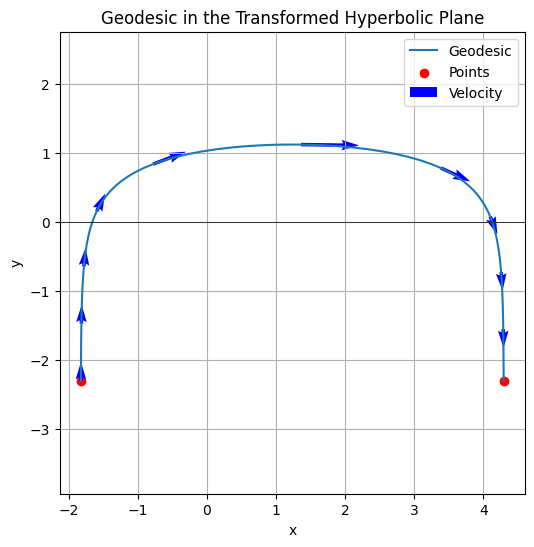

In [838]:
# Define the points
x0, y0 = torch.rand(1) * 10 - 5, torch.zeros(1)+ 0.1
x1, y1 = torch.rand(1) * 10 - 5, torch.zeros(1) + 0.1
# Transform the points
x0_t, y0_t = transform(x0, y0)
x1_t, y1_t = transform(x1, y1)

# Generate points along the geodesic in the transformed plane
t_values = torch.linspace(0, 1, 100).unsqueeze(1)
geodesic_points_t = [transform(*geodesic_point(x0, y0, x1, y1, t)) for t in t_values]
# Extract x and y coordinates
x_coords_t, y_coords_t = zip(*geodesic_points_t)

# Calculate velocities at the corresponding points along the geodesic in the transformed plane
velocities_t = [velocity_transform(*geodesic_velocity(x0, y0, x1, y1, t), *geodesic_point(x0, y0, x1, y1, t)) for t in t_values]
vx_coords_t, vy_coords_t = zip(*velocities_t)

# Plot the points and the geodesic in the transformed plane
plt.figure(figsize=(6, 6))
plt.plot(x_coords_t, y_coords_t, label='Geodesic')
plt.scatter([x0_t, x1_t], [y0_t, y1_t], color='red', label='Points')
plt.quiver(x_coords_t[::10], y_coords_t[::10], vx_coords_t[::10], vy_coords_t[::10], color='blue', label='Velocity')
plt.axhline(0, color='black',linewidth=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Geodesic in the Transformed Hyperbolic Plane')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [839]:
class HyperbolicDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, scale):
        self.num_samples = num_samples
        self.scale = scale

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        point = torch.normal(0, 1, (2,))
        point[1] = 0.1  # Set y-coordinate to 0.1
        return point

class BaseDistribution:
    def __init__(self, scale):
        self.scale = scale

    def sample(self, n_samples):
        x = torch.normal(0, self.scale, (n_samples, 2))
        x[:, 1] = torch.abs(x[:, 1]) + 0.1  # Ensure y > 0
        return x

In [840]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


class ConditionalFlowMatchingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flow = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, xt, yt, t):
        x = torch.cat((xt, yt, t), dim=1)
        return self.flow(x)

    def loss(self, x0, y0, x1, y1, t):
        xt, yt = geodesic_point(x0, y0, x1, y1, t)
        txt, tyt = transform(xt, yt)
        ptvt = self.forward(txt, tyt, t)
        ptvxt = ptvt[:, 0]
        ptvyt = ptvt[:, 1]
        pvxt, pvyt = velocity_inverse_transform(ptvxt, ptvyt, xt, yt)
        vxt, vyt = geodesic_velocity(x0, y0, x1, y1, t)
        loss = torch.mean((pvxt - vxt)**2 + (pvyt - vyt)**2)
        return loss

def train_model(model, base_distribution, dataset, num_epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        for batch in dataloader:
            optimizer.zero_grad()
            t = torch.rand(batch.size(0), 1)
            x0, y0 = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
            x1, y1 = base_distribution.sample(batch.size(0)).t()
            loss = model.loss(x0, y0, x1.unsqueeze(1), y1.unsqueeze(1), t)
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Define the base distribution and dataset
base_distribution = BaseDistribution(scale=1.0)
dataset = HyperbolicDataset(num_samples=1000000, scale = 2.0)

# Initialize the model
model = ConditionalFlowMatchingModel()

# Train the model
train_model(model, base_distribution, dataset)

Epoch 0
Epoch 0, Loss: 5.4961957931518555
Epoch 1
Epoch 2


KeyboardInterrupt: 

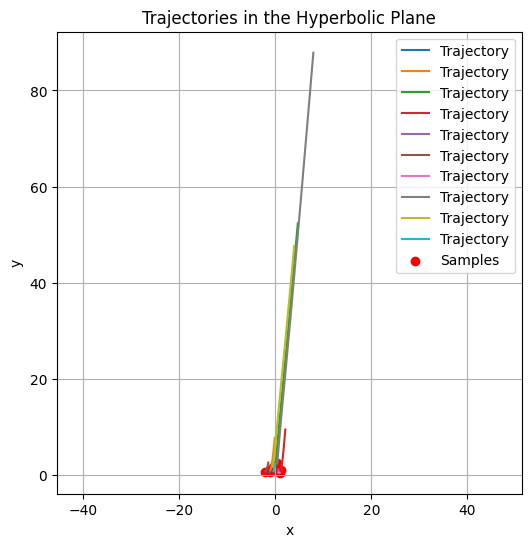

In [841]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt
# Define the ODE function
def ode_func(t, z):
    x, y = z[:, 0].unsqueeze(-1), z[:, 1].unsqueeze(-1)
    t = t.expand_as(x)
    return model.forward(x, y, t)

# Define the ODE solver
def ode_solver(model, x0, y0, t_values):
    z0 = torch.cat([x0, y0], dim = -1)
    sol = torchdiffeq.odeint(ode_func, z0, t_values, method='rk4')
    return sol[..., 0], sol[..., 1]

samples = base_distribution.sample(10)


# Generate trajectories using the ODE solver
t_values = torch.linspace(0, 1, 100)
trajectories = [ode_solver(model, sample[0].view(1,1), sample[1].view(1,1), t_values) for sample in samples]

# Plot the trajectories
plt.figure(figsize=(6, 6))
for traj in trajectories:
    x_coords, y_coords = traj
    plt.plot(x_coords.detach().numpy(), y_coords.detach().numpy(), label='Trajectory')
plt.scatter(samples[:, 0], samples[:, 1], color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories in the Hyperbolic Plane')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()